# Museums in the Pandemic - Extract indicators

**Authors**: Andrea Ballatore (KCL)

**Abstract**: Extract indicators from museum text.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [1]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
import random
import spacy
from termcolor import colored
import sys
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
from datetime import datetime
import seaborn as sns
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from museums import get_museums_w_web_urls, get_twitter_facebook_links, load_input_museums_wattributes, get_extra_museum_attributes
from utils import _is_number
from analytics.text_models import derive_new_attributes_matches, get_all_matches_from_db, get_indicator_annotations
from scrapers.scraper_websites import get_scraping_session_tables, get_session_id_from_table_name
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

print('env ok')

Conda env: mip_v1
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks_py
env ok


## Connect to DB

It needs the DCS VPN active to work.

In [2]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

def get_all_sessions():
    return sorted([get_session_id_from_table_name(x) for x in get_scraping_session_tables(db_conn)])

DB connected


## Extract matches for all museums

Using the best deep learning model defined above, find indicators for all museums (from websites and social media).

The manual annotation data with 700 cases is in `matches_valid_ann_df_v3.pik`.

### Load deep learning validation model

In [ ]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

def remove_duplicate_matches(df):
    # find duplicates
    n = len(df)
    df = df.drop_duplicates(subset=df.columns.difference(['page_id','sentence_id']))
    print('remove_duplicate_matches:',n,len(df))
    return df

def prep_match_data(df):
    for c in valid_model_columns:
        if not c in df.columns:
            print("Warning: column '{}' is missing, adding a zero column".format(c))
            df[c] = 0
    
    df = remove_duplicate_matches(df)
    df = df[valid_model_columns]
    assert len(df.columns) == 33, len(df.columns)
    num_df = df.select_dtypes(include=[np.number])
    scaler = MinMaxScaler()
    # fit and transform in one step
    cols = num_df.columns
    x_data = pd.DataFrame(scaler.fit_transform(num_df),columns=cols)
    return x_data

def convert_pred_to_bool(vals):
    pred_y = (vals > 0.5).astype("bool")
    # unpack results
    bool_vals = [item for sublist in pred_y for item in sublist]
    return bool_vals

In [ ]:
# MODEL COLUMNS
cols_fn = out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model_columns.csv"
valid_model_columns = pd.read_csv(cols_fn).iloc[:, 0].tolist()

valid_ann_df_fn = 'matches_valid_ann_df_v3.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

valid_match_cnn_model = load_model(out_folder+"data/analysis/matching_validation/matching_validation_deep_learning_model.h5")
valid_match_cnn_model

x_data = prep_match_data(valid_ann_df)
assert len(x_data.columns) == 33, len(x_data.columns)
print(x_data)
pred_valid = convert_pred_to_bool(valid_match_cnn_model.predict(x_data))

valid_ann_df['predicted_valid'] = pred_valid

#valid_ann_df.to_excel(out_folder+"tmp/check_deeplearning.xlsx",index=False)
valid_ann_df.sample(5)

In [ ]:
def aggr_indicators_by_indic(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

# extract indicator stats
#indf2 = valid_ann_df.indicator_code.value_counts().to_frame('valid_set_700_cases')
#indf2['indicator_code'] = indf2.index
#indf2

indf2 = pd.DataFrame()
for indic,subdf in valid_ann_df.groupby('indicator_code'):
    indf2 = indf2.append(aggr_indicators_by_indic(subdf))
indf2 = indf2.round(3)
indf2

### Load all matches from DB (slow)

- Dump all matches from DB, after running `an_text` on ALL museums for a given crawling session.

In [ ]:
# DB columns:
""" 
example_id indicator_code lemma_n lemma_n_wdupl token_n token_n_wdupl criticalwords_n criticalwords_n_wdupl sentence_id  sent_len
example_len example_crit_len ann_overlap_lemma ann_overlap_token ann_overlap_criticwords txt_overlap_lemma
txt_overlap_token ann_ex_tokens ann_ex_tokens page_tokens session_id page_id muse_id keep_stopwords
"""
sessions = get_all_sessions()
sessions = ['20210304','20210404','20210629','20210914'] # DEBUG

print("target sessions:", sessions)

# get all sessions from DB (slow)
if True: # debug
    for session_id in sessions:
        get_all_matches_from_db(session_id, db_conn, out_folder)
        

## Predict and save valid matches

Load matches from `../../tmp/matches_dump_df_<session>.pik`

Dump results in file `../../tmp/all_valid_matches_dump_df.pik`

In [ ]:
#sessions = ['20210304','20210404']

def select_and_merge_indicators(df):
    """ based on `indicator_code_stats_validation-v2.xlsx` """
    print('select_and_merge_indicators',df.shape)
    # drop invalid indicators
    invalid_indics = ['closed_perm','finance_health','funding_did_not_get',
                     'funding_other_emer','lang_difficulty','made_covid_safe',
                     'open_cafe','open_onlineshop','project_postpone',
                      'staff_hiring','staff_restruct']
    vdf = df[~df['indicator_code'].isin(invalid_indics)].copy()
    
    # merge indicators
    merged_indic = {'online_event':'online_engag',
                    'online_exhib':'online_engag',
                    'reopen_plan':'reopen_intent',
                    'funding_fundraise':'funding',
                    'funding_gov_emer':'funding',
                    'closed_indef':'closed_cur'}
    indicator_code_merged = vdf['indicator_code'].replace(merged_indic)
    vdf.loc[:,['indicator_code_merged']]=indicator_code_merged
    # compare results
    print(df['indicator_code'].value_counts())
    print(vdf['indicator_code_merged'].value_counts())
    print('  select_and_merge_indicators filtered:',vdf.shape)
    return vdf

def select_valid_matches(df, model):
    """ use Deep Learning model to validate matches """
    x_data = prep_match_data(df)
    
    print('select_valid_matches', x_data.shape)
    # check column order
    assert valid_model_columns == x_data.columns.tolist()
    print(x_data.shape)
    # apply model for predictions
    valid_int = model.predict(x_data)
    pred_valid = convert_pred_to_bool(valid_int)
    #print(type(pred_valid),len(pred_valid))
    df['valid_match'] = pred_valid
    print(df.valid_match.value_counts())
    return df

assert len(valid_model_columns) > 0
allsess_match_df = pd.DataFrame(columns=valid_model_columns)

print('sessions:', sessions)
for session_id in sessions:
    print('\n> session_id',session_id)
    matches_fn = out_folder+'tmp/matches_dump_df_{}.pik'.format(session_id)
    matchdf = pd.read_pickle(matches_fn)
    matchdf = remove_duplicate_matches(matchdf)
    #matchdf = matchdf.sample(100) # DEBUG
    print("\t", matches_fn, matchdf.shape)
    # apply model to get valid matches
    validmatch_df = select_valid_matches(matchdf, valid_match_cnn_model)
    # save sample to inspect results
    #validmatch_df.sample(200).to_csv(out_folder+'tmp/valid_matches_sample_{}.tsv'.format(session_id),sep='\t')
    # save results
    allsess_match_df = pd.concat([allsess_match_df, validmatch_df])
    del validmatch_df

allsess_match_df2 = select_and_merge_indicators(allsess_match_df)
allsess_match_df2 = remove_duplicate_matches(allsess_match_df2)
all_vmatches_fn = out_folder+'tmp/all_valid_matches_dump_df.pik'
print("valid matches vs invalid\n", allsess_match_df2.valid_match.value_counts())
print("sessions\n", allsess_match_df2.session_id.value_counts())
valdf = allsess_match_df2[allsess_match_df2.valid_match]
valdf.to_pickle(all_vmatches_fn)
print('valid matches for all sessions:', len(valdf), all_vmatches_fn)

In [ ]:
print(allsess_match_df.columns)
print("Matches from DB:")
round(allsess_match_df['valid_match'].value_counts()/len(allsess_match_df),2)

## [Aggregate indicators for extra evaluation]

This section extends and finalises the validation in notebook 01.

### Basic stats

In [ ]:
assert len(allsess_match_df) > 0
allsess_match_valid_df = allsess_match_df[allsess_match_df.valid_match]
allsess_match_valid_df = remove_duplicate_matches(allsess_match_valid_df)
print("N =", len(allsess_match_valid_df))
print("N museums =", len(allsess_match_valid_df.muse_id.unique()))
allsess_match_valid_df.head(100)

In [ ]:
# load annotations
indic_df, ann_df = get_indicator_annotations(out_folder)
del indic_df
# calculate n_indic_all_ann_examples
ann_stats_df = ann_df.groupby(['indicator_code']).size().reset_index(name='n_indic_all_ann_examples')
print(ann_df.head(30))
ann_stats_df

### Calculate precision of matching by indicator

This is to evaluate the performance by indicator to account for the high variability, as suggested by AP. 

- The results are in `indicator_code_stats_validation-v1.xlsx`. 
- Some indicators were removed.
- An extra evaluation was designed.

In [ ]:
# get indicator stats

def aggr_indicators_by_indic_allmatches(df):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['matches_ml_true'] = len(df)
    d['matches_ml_tot'] = len(allsess_match_df)
    d['matches_ml_pc'] = round(d['matches_ml_true'] / d['matches_ml_tot'],3)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat)>1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    return res

In [ ]:
indf3 = pd.DataFrame()
for indic,subdf in allsess_match_df.groupby('indicator_code'):
    indf3 = indf3.append(aggr_indicators_by_indic_allmatches(subdf))

indf3 = indf3.reset_index()
indf3 = indf3.merge(indf2,on='indicator_code',how='outer')
indf3 = indf3.merge(ann_stats_df,on='indicator_code',how='outer')
indf3.to_excel(out_folder+'tmp/indicator_code_stats_validation.xlsx',index=False)
indf3

Aggregate indicator stats by sentence.

In [ ]:
col_aggr = ['muse_id','session_id','page_id','indicator_code','n_indic_all_ann_examples']

def aggr_indicators_sent(df):
    d = {}
    for c in col_aggr:
        d[c] = df[c].tolist()[0]
    d['n_uniq_sentences'] = df['sentence_id'].nunique()
    d['n_matched_annotations'] = df['example_id'].nunique()
    d['n_matches'] = len(df)
    d['matches_to_sent_ratio'] = round(d['n_matches'] / d['n_uniq_sentences'],3)
    d['matches_to_example_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    #d['matches_ratio'] = round(d['n_matches'] / d['n_indic_all_ann_examples'],3)
    return pd.Series(d)

n = len(allsess_match_valid_df)
allsess_match_valid_df2 = allsess_match_valid_df.merge(ann_stats_df, on='indicator_code')
assert n == len(allsess_match_valid_df2)

muse_indic_sent_df = allsess_match_valid_df2.groupby(col_aggr).apply(aggr_indicators_sent)
print(muse_indic_sent_df.columns)
muse_indic_sent_df.reset_index(drop=True, inplace=True)
muse_indic_sent_df = muse_indic_sent_df.sort_values(['session_id','muse_id','indicator_code'])
#print(muse_indic_sent_df.session_id.value_counts())
muse_indic_sent_df.to_excel(out_folder+'tmp/museum_indicators_sent_stats-v1.xlsx', index=False)
muse_indic_sent_df.head(30)

### Museum indic matches sample for extra validation - v1

Annotations done in `museum_website_match_sample10_summary-v1.xlsx`

In [ ]:
musem_sample_ids = muse_indic_sent_df.muse_id.sample(10,random_state=10)
muse_sample_df = muse_indic_sent_df[muse_indic_sent_df.muse_id.isin(musem_sample_ids)]
muse_sample_df.to_excel(out_folder+'tmp/museum_website_match_sample10_summary.xlsx',index=False)
allsess_match_valid_df[allsess_match_valid_df.muse_id.isin(musem_sample_ids)].to_excel(out_folder+'tmp/museum_website_match_sample10_matches.xlsx',index=False)

muse_sample_df

### Museum indic matches sample for extra validation - v2

- Select random sample from museums where matches > 0, 5 museums for 2 snapshots, for cases that need more investigation in `indicator_code_stats_validation-v1`
- Indicators to include: finance_health, lang_difficulty, staff_working
- Finance_health appears only in 2 museums, so we will discard it.
- The sample is in
  - `museum_website_match_sample5_lang_staff_summary-v1.xlsx`: stats for the 10 museums.
  - `museum_website_match_sample5_lang_staff-v1.xlsx`: sample of 200 detailed matches.
  
- The manual annotations are in `museum_website_match_sample5_lang_staff-v2.xlsx` and `museum_website_match_sample5_lang_staff_summary-v2.xlsx`.

In [ ]:
assert len(allsess_match_valid_df) > 0
assert len(allsess_match_df) > 0

print('allsess_match_valid_df N =',len(allsess_match_valid_df))

df = allsess_match_valid_df[['muse_id','indicator_code']].drop_duplicates()
muse_indic_df = df['indicator_code'].value_counts()
print(muse_indic_df)
del df

random.seed(422)

res = pd.DataFrame()
res_all = pd.DataFrame()
for indic in ['lang_difficulty', 'staff_working']:
    print('\n>> indicator:', indic)
    mus_df = allsess_match_valid_df[allsess_match_valid_df['indicator_code'] == indic]
    mus_df2 = allsess_match_df[allsess_match_df['indicator_code'] == indic]
    mus_ids = random.sample(list(mus_df.muse_id.unique()), 5)
    print(mus_ids)
    # get sample for annotation
    sample_df = mus_df2[mus_df2.muse_id.isin(mus_ids)]
    print(len(sample_df))
    print(sample_df.valid_match.value_counts())
    #if indic == 'lang_difficulty':
    #    df1 = sample_df[sample_df.valid_match]
    #    neg_df = sample_df[sample_df.valid_match==False]
    #    print('XXX', len(neg_df), len(df1))
    #    df1.append(neg_df.sample(92))
    #else:
    df1 = sample_df.sample(100)
        
    res_all = res_all.append(sample_df)
    print('\nSample', len(df1), df1.valid_match.value_counts())
    print(df1['muse_id'].unique())
    print(df1['session_id'].unique())
    res = res.append(df1)
    del df1, mus_df2

# add stats
res_all = res_all.merge(ann_stats_df,on='indicator_code')

# generate detailed results
res.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff.xlsx',index=False)

In [ ]:
# generate summary
res_all
print(col_aggr)
df3 = res_all.groupby(col_aggr).apply(aggr_indicators_sent)
df3.to_excel(out_folder+'tmp/museum_website_match_sample5_lang_staff_summary.xlsx',index=False)
del df3

#### Calculating precision of extra validation

In [ ]:
# load extra validation for language_difficulty and staff_working
vdf = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample5_lang_staff-v2.xlsx')
print(len(vdf))

vdf['predicted_valid'] = vdf.valid_match
vdf['valid_match_b'] = vdf['valid_PW'].map({'T': True, 'F': False})
vdf

In [ ]:
indf4 = pd.DataFrame()
for indic,df in vdf.groupby('indicator_code'):
    d = {}
    for c in ['indicator_code']:
        d[c] = df[c].tolist()[0]
    d['cases_700'] = len(df)
    print(df.columns)
    d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    if len(confmat) > 1:
        d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    for k,v in d.items():
        d[k] = [v]
        
    res = pd.DataFrame.from_dict(d)
    indf4 = indf4.append(res)

indf4 = indf4.reset_index()
indf4

In [ ]:
sum_df = pd.read_excel(out_folder+'data/annotations/museum_website_match_sample10_summary-v1.xlsx')
sum_df['valid'] = sum_df['2nd Validator (ap)'].map({'T': True, 'F': False})
print(len(sum_df))

indf2 = pd.DataFrame()
for indic, df in sum_df.groupby('indicator_code'):
    d = {'indicator_code': indic}
    d['cases_n'] = len(df)
    #print(df.columns)
    #d['precision'], d['recall'], d['fscore'], support = precision_recall_fscore_support(df.valid_match_b, df.predicted_valid, average='binary')
    #confmat = confusion_matrix(df.valid_match_b, df.predicted_valid, normalize='all')
    #if len(confmat) > 1:
    #    d['tn'], d['fp'], d['fn'], d['tp'] = confmat.ravel()
    tdf = df[df['valid']]
    fdf = df[~df['valid']]
    d['cases_true'] = len(tdf)
    d['cases_false'] = len(fdf)
    d['indic_mus_accuracy'] = d['cases_true']/d['cases_n']
    for k,v in d.items():
        d[k] = [v]
    res = pd.DataFrame.from_dict(d).round(2)
    indf2 = indf2.append(res)

# add extra validation
#Staff_working	6	2	75%
#Language_of_difficulty	6	3	67%

indf2 = indf2.append(pd.DataFrame({'indicator_code':['lang_difficulty'], 'indic_mus_accuracy':[.67]}))

indf2 = indf2.sort_values('indicator_code').reset_index()
indf2.to_excel(out_folder+'tmp/indicator_code_stats_validation-v3.xlsx',index=False)
indf2

### Selection of valid indicators

Based on the validation on the validation by indicator and by museum discussed above, these are the selected indicators.
Main file: summary of indicator validation statistics on MS Teams: `indicator_code_stats_validation-v2.xlsx`.

**Summary of validation process**
- Three iterations of 700 matches for all indicators. Eval data v3 includes sem_similarity and critical_words). THe sample was stratified over overlap value on two groups: low and high values, to ensure that the sample contained enough TRUE cases (`[0, .45, 1.01]`). Result: 70% false, 30% true (TBC).
- Intially, we calculated the overall performance metrics, but then we realised that there was high inter-indicator variability.
- Sample at the museum level, as opposed to the single indicator level. Sample of 10 random museums including all matches for two time slots (Museum indic matches sample for extra validation - v1). PW and AP annotated the sample. The resulting metrics were generated in `indicator_code_stats_validation-v1.xlsx`.
- We selected indicators (YES/NO/merge/further investigation).
- Sample only for `finance_health, lang_difficulty, staff_working`, 5 random museums with non-zero matches  for each indicator (100 matches for each of the three groups).


**Inclusion criteria**:
- No. of cases in the evaluation dataset (reflecting distribution of complete data): > 10 cases
- Precision: > .7 (exception: `online_event`)
- Recall: no minimum
- F-score: no minimum
- Accuracy (by museum): > .67

**Merge criteria** (for 5 indicators):
- recall is less important because we are looking for trends over time, not absolute counts.
- precision > .8 (exception: `online_event`)
- semantic ambiguity (the two indicators are indistinguishable)

**Decision**:
- Valid indicators: `closed_cur funding_fundraise funding_gov_emer online_engag open_cur open_onlineshop reopen_intent`


## Summarise and viz indicators

Load and viz indicators from `../../tmp/all_valid_matches_dump_df.pik`.

### Load indicators

In [56]:
indf = pd.read_pickle("../../tmp/all_valid_matches_dump_df.pik")
print(indf.shape)
#indf = indf.sample(500) # DEBUG
print(indf['session_id'].value_counts())

indf.sample(10)

an_folder = out_folder+'data/analysis/indicators/'
an_folder

(310173, 43)
20210404    84366
20210304    83330
20210629    78419
20210914    64058
Name: session_id, dtype: int64


'../../data/analysis/indicators/'

### Indicators over time

In [58]:
def sessionid_to_time(session_id):
    dd = datetime.strptime(session_id, '%Y%m%d')
    return dd

mus_indic_df = indf.groupby(['session_id','muse_id','indicator_code_merged'], as_index=False).size()
mus_indic_df = mus_indic_df.rename(columns={'size':'n_indicator_matches'})
#mus_indic_df['mus_websites_n'] = mus_indic_df['muse_id'].nunique()
mus_indic_df['session_time'] = mus_indic_df['session_id'].apply(sessionid_to_time)
mus_indic_df.to_excel(an_folder+'museums_indicators_sessions.xlsx',index=False)
mus_indic_df

,session_id,muse_id,indicator_code_merged,n_indicator_matches,session_time
0,20210304,domus.NE043,closed_cur,7,2021-03-04
1,20210304,domus.NE043,online_engag,2,2021-03-04
2,20210304,domus.NE043,open_cur,1,2021-03-04
3,20210304,domus.NE043,reopen_intent,4,2021-03-04
4,20210304,mm.MDN.006,closed_cur,11,2021-03-04
...,...,...,...,...,...
45182,20210914,mm.wiki.504,funding,1,2021-09-14
45183,20210914,mm.wiki.504,online_engag,3,2021-09-14
45184,20210914,mm.wiki.504,reopen_intent,1,2021-09-14
45185,20210914,mm.wiki.505,online_engag,4,2021-09-14


In [59]:
mus_indic_unique_df = mus_indic_df.groupby(['session_id'], as_index=False).nunique()
mus_indic_unique_df = mus_indic_unique_df.rename(columns={'muse_id':'n_sess_museums'})
mus_indic_unique_df = mus_indic_unique_df[['session_id','n_sess_museums']]
mus_indic_unique_df

,session_id,n_sess_museums
0,20210304,3018
1,20210404,3032
2,20210629,3057
3,20210914,3047


In [60]:
mus_indic_counts_df = mus_indic_df.groupby(['session_id','indicator_code_merged'], as_index=False).size()
mus_indic_counts_df = mus_indic_counts_df.rename(columns={'size':'n_museums'})
mus_indic_counts_df = mus_indic_counts_df.merge(mus_indic_unique_df, on='session_id', how='left')

mus_indic_counts_df['indic_museum_pc'] = mus_indic_counts_df['n_museums'] / mus_indic_counts_df['n_sess_museums'] * 100
mus_indic_counts_df['indic_museum_pc'] = round(mus_indic_counts_df['indic_museum_pc'],1)
mus_indic_counts_df['session_time'] = mus_indic_counts_df['session_id'].apply(sessionid_to_time)
mus_indic_counts_df

,session_id,indicator_code_merged,n_museums,n_sess_museums,indic_museum_pc,session_time
0,20210304,closed_cur,2253,3018,74.7,2021-03-04
1,20210304,funding,1115,3018,36.9,2021-03-04
2,20210304,online_engag,2701,3018,89.5,2021-03-04
3,20210304,open_cur,1477,3018,48.9,2021-03-04
4,20210304,reopen_intent,2421,3018,80.2,2021-03-04
5,20210304,staff_working,1355,3018,44.9,2021-03-04
6,20210404,closed_cur,2256,3032,74.4,2021-04-04
7,20210404,funding,1161,3032,38.3,2021-04-04
8,20210404,online_engag,2726,3032,89.9,2021-04-04
9,20210404,open_cur,1531,3032,50.5,2021-04-04


In [129]:
sns.set_style("whitegrid")
g = sns.lineplot(data=mus_indic_counts_df, x="session_time", y="n_museums", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
# move legend outside
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(an_folder+'indicators_over_time-n_museums.pdf',bbox_inches='tight')
plt.clf()

g = sns.lineplot(data=mus_indic_counts_df, x="session_time", y="indic_museum_pc", markers=True,
             hue="indicator_code_merged", style="indicator_code_merged")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(an_folder+'indicators_over_time-n_museums_pc.pdf',bbox_inches='tight')
plt.clf()

<Figure size 432x288 with 0 Axes>

### Pivot indicators over attributes

In [63]:
len(mus_indic_df)
mdf = load_input_museums_wattributes(out_folder)
mdf = get_extra_museum_attributes(mdf)
mus_indic_attrib_df = mus_indic_df.merge(mdf, on='muse_id', how='left')
print('df rows=',len(mus_indic_attrib_df))
print(mus_indic_attrib_df.columns)
mus_indic_attrib_df.sample(10)

Index(['musname', 'muse_id', 'town', 'postcode', 'accreditation', 'governance',
       'size', 'subject_matter', 'closing_date', 'provenance',
       'deprivation_index', 'geodemographic_group', 'geodemographic_subgroup',
       'admin_area'],
      dtype='object')
loaded museums w attributes (open): 3341 data/museums/museums_wattributes-2020-02-23.tsv
independent    2399
government      795
university       92
unknown          55
Name: governance_simpl, dtype: int64
England             2507
Scotland             494
Wales                207
Northern Ireland      94
Channel Islands       24
Isle of Man           15
Name: country, dtype: int64
Scotland                     494
South East                   476
South West                   422
East of England              333
North West                   247
London                       238
Yorkshire and The Humber     229
East Midlands                229
West Midlands                228
Wales                        207
North East          

/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/museums.py:401: FutureWarning: The default value of regex will change from True to False in a future version.
  df['region'] = df['region'].str.replace('\(English Region\)','')


,session_id,muse_id,indicator_code_merged,n_indicator_matches,session_time,musname,town,postcode,accreditation,governance,...,closing_date,provenance,deprivation_index,geodemographic_group,geodemographic_subgroup,admin_area,governance_simpl,subject_matter_simpl,country,region
36659,20210914,mm.domus.NE005,open_cur,1,2021-09-14,"Jarrow Hall - Anglo Saxon Farm, Village And Be...",Jarrow,NE32 3DY,Unaccredited,Independent:Not for profit,...,Still open,domus,1.0,Services Manufacturing and Mining Legacy,Service Economy,/England/North East (English Region)/North Eas...,independent,Personality,England,North East
38458,20210914,mm.domus.SE050,reopen_intent,7,2021-09-14,Museum Of Richmond,Richmond-upon-Thames,TW9 1TP,Accredited,Independent:Not for profit,...,Still open,domus,8.0,Rural-Urban Fringe,Rural-Urban Fringe,/England/London (English Region)/Richmond upon...,independent,Local Histories,England,London
18028,20210404,mm.domus.SW165,closed_cur,3,2021-04-04,Padstow Museum,Padstow,PL28 8AD,Accredited,Independent:Not for profit,...,Still open,domus,3.0,Remoter Coastal Living,Ageing Coastal Living,/England/South West (English Region)/Cornwall ...,independent,Local Histories,England,South West
29050,20210629,mm.domus.SW034,open_cur,1,2021-06-29,Cricklade Museum,Cricklade,SN6 6DD,Unaccredited,Independent:Not for profit,...,Still open,domus,9.0,Country Living,Country Living,/England/South West (English Region)/Wiltshire...,independent,Local Histories,England,South West
28089,20210629,mm.domus.SE364,open_cur,5,2021-06-29,Verulamium Museum,St Albans,AL3 4SW,Accredited,Government:Local Authority,...,Still open,domus,10.0,Rural-Urban Fringe,Rural-Urban Fringe,/England/East of England (English Region)/Hert...,government,Archaeology,England,East of England
42736,20210914,mm.hha.187,closed_cur,1,2021-09-14,Fonmon Castle,Barry,CF62 3ZN,Unaccredited,Independent:Private,...,Still open,hha,9.0,Town Living,Prosperous Towns,/Wales/Vale of Glamorgan (Welsh UA),independent,War and conflict,Wales,Wales
18499,20210404,mm.domus.WA052,staff_working,3,2021-04-04,Tredegar House And Park,Newport,NP10 8YW,Accredited,Independent:National Trust,...,Still open,domus,8.0,Manufacturing Traits,Industrial and Multi-ethnic,/Wales/Newport (Welsh UA),independent,Buildings,Wales,Wales
11129,20210304,mm.wiki.393,open_cur,2,2021-03-04,Arundells,Salisbury,SP1 2EN,Unaccredited,Independent:Not for profit,...,Still open,wiki,5.0,Country Living,Country Living,/England/South West (English Region)/Wiltshire...,independent,Personality,England,South West
3433,20210304,mm.domus.SC017,closed_cur,1,2021-03-04,Annan Museum,Annan,DG12 6AA,Accredited,Government:Local Authority,...,Still open,domus,4.0,Scottish Countryside,Scottish Countryside,/Scotland/Dumfries and Galloway (Scottish Coun...,government,Local Histories,Scotland,Scotland
44979,20210914,mm.wiki.381,online_engag,1,2021-09-14,Dewsbury Minster Heritage Centre,Dewsbury,WF12 8DD,Unaccredited,Independent:Not for profit,...,Still open,wiki,1.0,Manufacturing Traits,Industrial and Multi-ethnic,/England/Yorkshire and The Humber (English Reg...,independent,Belief and identity,England,Yorkshire and The Humber


In [128]:
for x in [an_folder+'/indic_pivot_tables/']:
    print(x)
    if not os.path.exists(x):
        os.makedirs(x)

def plot_indic_small_mult(df, col, group_var, y_var, y_label, fold):
    # plot line chart of indicators (small multiples)
    print('plot_indic_small_mult', col, group_var)
    g = sns.FacetGrid(df, col=col, col_wrap=6)
    g.map_dataframe(sns.lineplot, x="session_time", y=y_var, hue=group_var, style=group_var, marker='.')
    g.add_legend() #loc='lower right')

    # fix up axes and labels
    [ax.set(ylabel=y_label) for ax in g.axes.flat]
    #for ax in g.axes.flatten():
    #    ax.tick_params(labelbottom=True)
    [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
    # save figure
    figfn = "{}/indic_linechart-{}-{}-{}.pdf".format(fold, col, group_var, y_label.lower().replace(' ','_'))
    #plt.tight_layout()
    plt.savefig(figfn,bbox_inches='tight')
    plt.clf()
    print(figfn)
        
def pivot_indic_by_attributes(df, col, mus_df):
    """ generate indicators pivoted by attributes """
    assert col
    print("> pivot_indic_by_attributes:",col)
    fold = an_folder+'/indic_pivot_tables/indic-'+col+'/'
    if not os.path.exists(fold): os.makedirs(fold)
    # calc museum totals 
    mus_counts_df = mus_df.groupby(col).size().to_frame('tot_attr_museums').reset_index()
    # fix for size ('size' is reserved in pandas)
    print(mus_counts_df.columns)
    if 'size' in mus_counts_df.columns:
        mus_counts_df = mus_counts_df.rename(columns={'size':'m_size'})
        col = 'm_size'
    #print(mus_counts_df)
    
    df = df.copy()
    df = df.rename(columns={'size':'m_size'})
    cols = ['session_id','indicator_code_merged']
    cols.append(col)
    piv_df = df.groupby(cols, as_index=False).size()
    piv_df = piv_df.merge(mus_counts_df, on=col, how='left')
    
    piv_df['indic_museum_attr_pc'] = round(piv_df['size'] / piv_df['tot_attr_museums'] * 100,1)
    piv_df['session_time'] = piv_df['session_id'].apply(sessionid_to_time)
    fn = "{}/indic_counts-{}.xlsx".format(fold, col)
    print(fn)
    piv_df.to_excel(fn, index=False)
    
    # plot line chart of indicators (small multiples)
    # plot 1 by indicators
    plot_indic_small_mult(piv_df, 'indicator_code_merged', col, 'size', 'N museums', fold)
    plot_indic_small_mult(piv_df, col, 'indicator_code_merged', 'size', 'N museums', fold)
    plot_indic_small_mult(piv_df, 'indicator_code_merged', col, 'indic_museum_attr_pc', 'PC museums', fold)
    plot_indic_small_mult(piv_df, col, 'indicator_code_merged', 'indic_museum_attr_pc', 'PC museums', fold)
    
    return piv_df

attrib_combs = ['governance_simpl','size','governance','region','country','subject_matter_simpl']
#attrib_combs = ['governance_simpl'] # DEBUG
for attrs in attrib_combs:
    df = pivot_indic_by_attributes(mus_indic_attrib_df, attrs, mdf)

../../data/analysis/indicators//indic_pivot_tables/
> pivot_indic_by_attributes: governance_simpl
Index(['governance_simpl', 'tot_attr_museums'], dtype='object')
../../data/analysis/indicators//indic_pivot_tables/indic-governance_simpl//indic_counts-governance_simpl.xlsx
plot_indic_small_mult indicator_code_merged governance_simpl
../../data/analysis/indicators//indic_pivot_tables/indic-governance_simpl//indic_linechart-indicator_code_merged-governance_simpl-n_museums.pdf
plot_indic_small_mult governance_simpl indicator_code_merged
../../data/analysis/indicators//indic_pivot_tables/indic-governance_simpl//indic_linechart-governance_simpl-indicator_code_merged-n_museums.pdf
plot_indic_small_mult indicator_code_merged governance_simpl
../../data/analysis/indicators//indic_pivot_tables/indic-governance_simpl//indic_linechart-indicator_code_merged-governance_simpl-pc_museums.pdf
plot_indic_small_mult governance_simpl indicator_code_merged
../../data/analysis/indicators//indic_pivot_tables/

<Figure size 1387.25x216 with 0 Axes>

<Figure size 1393.5x216 with 0 Axes>

<Figure size 1387.25x216 with 0 Axes>

<Figure size 1393.5x216 with 0 Axes>

<Figure size 1372.38x216 with 0 Axes>

<Figure size 1393.5x216 with 0 Axes>

<Figure size 1372.38x216 with 0 Axes>

<Figure size 1393.5x216 with 0 Axes>

<Figure size 1525.25x216 with 0 Axes>

<Figure size 1393.5x648 with 0 Axes>

<Figure size 1525.25x216 with 0 Axes>

<Figure size 1393.5x648 with 0 Axes>

<Figure size 1453.88x216 with 0 Axes>

<Figure size 1393.5x648 with 0 Axes>

<Figure size 1453.88x216 with 0 Axes>

<Figure size 1393.5x648 with 0 Axes>

<Figure size 1446.38x216 with 0 Axes>

<Figure size 1393.5x864 with 0 Axes>

<Figure size 1446.38x216 with 0 Axes>

<Figure size 1393.5x864 with 0 Axes>

In [99]:
df = pivot_indic_by_attributes(mus_indic_attrib_df, 'governance_simpl', mdf)

> pivot_indic_by_attributes: governance_simpl
Index(['governance_simpl', 'tot_attr_museums'], dtype='object')
../../data/analysis/indicators//indic_pivot_tables/indic-governance_simpl//indic_counts-governance_simpl.xlsx
plot_indic_small_mult indicator_code_merged governance_simpl
../../data/analysis/indicators//indic_pivot_tables/indic-governance_simpl//indic_counts_linechart-indicator_code_merged-governance_simpl.pdf
plot_indic_small_mult governance_simpl indicator_code_merged
../../data/analysis/indicators//indic_pivot_tables/indic-governance_simpl//indic_counts_linechart-governance_simpl-indicator_code_merged.pdf


<Figure size 739.25x432 with 0 Axes>

<Figure size 761.25x432 with 0 Axes>

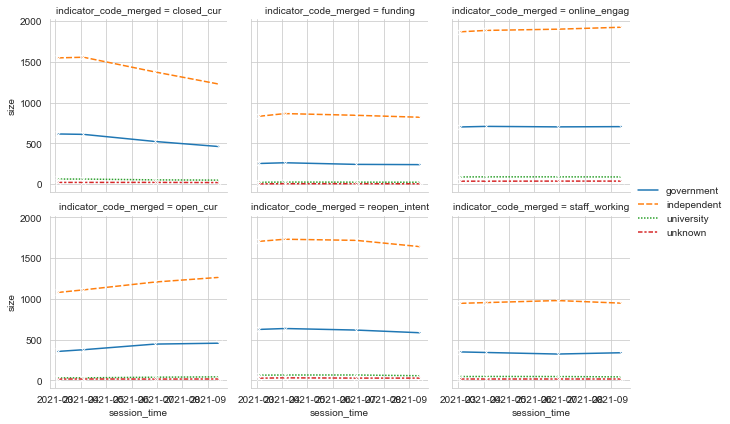

In [105]:
g = sns.FacetGrid(df, col='indicator_code_merged', col_wrap=3)
g.map_dataframe(sns.lineplot, x="session_time", y="size", hue='governance_simpl', style='governance_simpl', marker='x')
g.add_legend()
g

End of notebook.